# Text improvement engine - Development process

## Notebook Outline

### Summary

### Spacy Approach
- **Initial Approach**
- **Testing Different POS Combinations**
- **Analyzing Results**

### BERT Approach
- **Initial Approach**
- **BERT + Spacy Phrases**

### Comparative Analysis
- **Comparing BERT and BERT + Spacy Phrases**
- **Comparing Spacy and BERT Approaches**

### Conclusions
- **Summary**


## Summary

For this task, two approaches were considered: Spacy and BERT.

**Approach 1:** The Spacy approach uses the Spacy library to extract phrases from a sample text and match them with predefined standardized phrases based on similarity measures. The sample text is processed to identify key phrases involving verbs and other Parts of Speech (POS) and filtered for irrelevant words (stopwords).

**Approach 2:** The BERT approach breaks the sample text into sentences and further splits each sentence into phrases, calculates similarity scores against standardized phrases using a BERT model, and identifies the closest matches. The BERT approach was enhanced by adding Spacy phrases.



For submission **Approach 1** was chosen. While the BERT + Spacy approach shows promising results with scores over 0.8, the contextual relevance of the suggestions is higher for the Spacy approach alone.

## Spacy Approach

This approach uses the Spacy library to extract phrases from a sample text and match them with predefined standardized phrases based on similarity measures. The sample text is processed to identify key phrases involving verbs and other Parts of Speech (POS). These extracted phrases are filtered  to remove those that are too generic or contextually irrelevant and compared to the standardized phrases using cosine similarity, Jaccard similarity, and Levenshtein similarity. The results are weighted and grouped to provide suggestions for aligning the original phrases with the standardized ones.

### Initial approach

In [7]:
import subprocess
command = "python -m spacy download en_core_web_lg"
process = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)


In [8]:
import spacy
from sklearn.metrics import jaccard_score
from difflib import SequenceMatcher
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

nlp = spacy.load("en_core_web_lg")

# The sample text and phrases are explicitly defined for ease of use within Google Colab and for demonstration purposes in this notebook.
sample_text = """In today's meeting, we discussed a variety of issues affecting our department.
The weather was unusually sunny, a pleasant backdrop to our serious discussions.
We came to the consensus that we need to do better in terms of performance.
Sally brought doughnuts, which lightened the mood. It's important to make good use of what we have at our disposal.
During the coffee break, we talked about the upcoming company picnic.
We should aim to be more efficient and look for ways to be more creative in our daily tasks.
Growth is essential for our future, but equally important is building strong relationships with our team members.
As a reminder, the annual staff survey is due next Friday.
Lastly, we agreed that we must take time to look over our plans carefully and consider all angles before moving forward.
On a side note, David mentioned that his cat is recovering well from surgery."""

standardized_phrases = [
    "Optimal performance", "Utilise resources", "Enhance productivity", "Conduct an analysis",
    "Maintain a high standard", "Implement best practices", "Ensure compliance",
    "Streamline operations", "Foster innovation", "Drive growth", "Leverage synergies",
    "Demonstrate leadership", "Exercise due diligence", "Maximize stakeholder value",
    "Prioritise tasks", "Facilitate collaboration", "Monitor performance metrics",
    "Execute strategies", "Gauge effectiveness", "Champion change"
]



# Generate embeddings for standardized phrases
standardized_docs = [nlp(text) for text in standardized_phrases]

# convert the sample text into a Spacy Doc object
doc = nlp(sample_text)

# Define minimum number of words for filtering
min_words = 2

# Extract phrases with specific POS
phrases = []
for token in doc:
    if token.pos_ in {"VERB"} and token.text.lower() not in ENGLISH_STOP_WORDS:
#    if token.pos_ in {"VERB", "NOUN", "ADJ"} and token.text.lower() not in ENGLISH_STOP_WORDS:
        phrase = doc[token.left_edge.i:token.right_edge.i + 1]
        # Filter out phrases that are too generic or contextually irrelevant
        if len(phrase) > min_words and not all(word.text.lower() in ENGLISH_STOP_WORDS for word in phrase):
            phrases.append(phrase)

filtered_phrases = list(set(phrases))

#  calculate Jaccard similarity
def jaccard_similarity(doc1, doc2):
    a = set([word for word in doc1.lower().split() if word not in ENGLISH_STOP_WORDS])
    b = set([word for word in doc2.lower().split() if word not in ENGLISH_STOP_WORDS])
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c)) if (len(a) + len(b) - len(c)) != 0 else 0

#  calculate Levenshtein similarity
def levenshtein_similarity(doc1, doc2):
    return SequenceMatcher(None, doc1, doc2).ratio()

# Iterate over filtered phrases in the document
suggestions = []
for phrase in filtered_phrases:
    for std_doc in standardized_docs:
        cosine_similarity = phrase.similarity(std_doc)  # Cosine similarity
        jaccard_sim = jaccard_similarity(phrase.text, std_doc.text)
        levenshtein_sim = levenshtein_similarity(phrase.text, std_doc.text)

        # Apply weights to different similarity measures
        combined_similarity = 1 * cosine_similarity + 0.0 * jaccard_sim + 0.0 * levenshtein_sim

       # if combined_similarity > 0.6:
        if cosine_similarity > 0.0:
            suggestions.append({
                'original_phrase': phrase.text.strip(),
                'suggested_standard_phrase': std_doc.text,
                'similarity_score': cosine_similarity
            })

# Sort suggestions by similarity score
suggestions = sorted(suggestions, key=lambda x: x['similarity_score'], reverse=True)

from collections import defaultdict

# Create a dictionary to hold the suggestions
phrase_suggestions = defaultdict(list)

# Populate the dictionary with suggestions
for suggestion in suggestions:
    phrase_suggestions[suggestion['original_phrase']].append(suggestion)

# Print each phrase with its top corresponding suggestions
for phrase, sug_list in phrase_suggestions.items():
    print(f"\nOriginal Phrase: {phrase}")
    for suggestion in sug_list[:3]:  # Top suggestions
        print(f"  Suggestion: {suggestion['suggested_standard_phrase']} - Score: {suggestion['similarity_score']:.2f}")

scores = [suggestion['similarity_score'] for suggestion in suggestions]




Original Phrase: equally important is building strong relationships with our team members.
  Suggestion: Implement best practices - Score: 0.70
  Suggestion: Demonstrate leadership - Score: 0.70
  Suggestion: Enhance productivity - Score: 0.65

Original Phrase: look for ways to be more creative in our daily tasks
  Suggestion: Implement best practices - Score: 0.66
  Suggestion: Prioritise tasks - Score: 0.64
  Suggestion: Execute strategies - Score: 0.62

Original Phrase: affecting our department
  Suggestion: Ensure compliance - Score: 0.66
  Suggestion: Implement best practices - Score: 0.66
  Suggestion: Enhance productivity - Score: 0.63

Original Phrase: to look over our plans carefully and consider all angles before moving forward
  Suggestion: Implement best practices - Score: 0.65
  Suggestion: Ensure compliance - Score: 0.62
  Suggestion: Execute strategies - Score: 0.59

Original Phrase: We should aim to be more efficient and look for ways to be more creative in our daily t

Mean: 0.47
Median: 0.48
Standard Deviation: 0.10
Skewness: -0.30
Kurtosis: -0.18
Range: 0.48
Variance: 0.01
25th Percentile: 0.41
75th Percentile: 0.54
Interquartile Range (IQR): 0.13


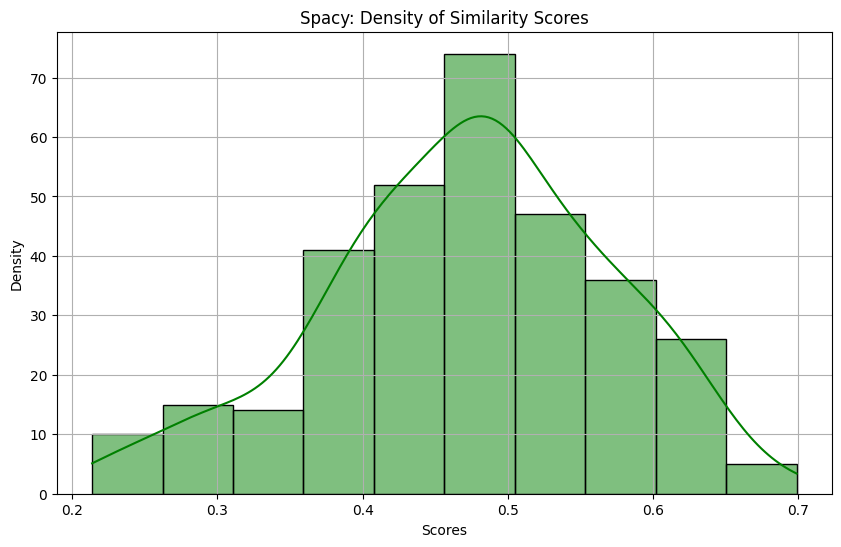

In [9]:
import numpy as np
from scipy.stats import skew, kurtosis

#  Calculate descriptive statistics
mean_score = np.mean(scores)
median_score = np.median(scores)
std_deviation = np.std(scores)
skewness = skew(scores)
kurt = kurtosis(scores)
range_score = np.ptp(scores)
variance = np.var(scores)
percentile_25 = np.percentile(scores, 25)
percentile_75 = np.percentile(scores, 75)
iqr = percentile_75 - percentile_25


print(f"Mean: {mean_score:.2f}")
print(f"Median: {median_score:.2f}")
print(f"Standard Deviation: {std_deviation:.2f}")
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurt:.2f}")
print(f"Range: {range_score:.2f}")
print(f"Variance: {variance:.2f}")
print(f"25th Percentile: {percentile_25:.2f}")
print(f"75th Percentile: {percentile_75:.2f}")
print(f"Interquartile Range (IQR): {iqr:.2f}")


# Plotting the histogram and KDE of the scores

plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, color='green', bins=10)
plt.title('Spacy: Density of Similarity Scores')
plt.xlabel('Scores')
plt.ylabel('Density')
plt.grid(True)
plt.show()

### Testing different POS combinations

In [10]:
pos_combinations = [
    {"VERB"},
    {"NOUN"},
    {"ADJ"},
    {"PROPN"},
    {"ADV"},
    {"VERB", "NOUN"},
    {"VERB", "ADJ"},
    {"NOUN", "ADJ"},
    {"VERB", "PROPN"},
    {"NOUN", "PROPN"},
    {"VERB", "NOUN", "ADJ"},
    {"VERB", "NOUN", "PROPN", "ADJ", "ADV"},
    {"VERB", "ADV"},
    {"NOUN", "ADV"},
    {"ADJ", "PROPN"},
    {"ADJ", "ADV"},
    {"PROPN", "ADV"},
    {"VERB", "NOUN", "PROPN"},
    {"VERB", "NOUN", "ADV"},
    {"VERB", "ADJ", "PROPN"},
    {"VERB", "ADJ", "ADV"},
    {"VERB", "PROPN", "ADV"},
    {"NOUN", "ADJ", "PROPN"},
    {"NOUN", "ADJ", "ADV"},
    {"NOUN", "PROPN", "ADV"},
    {"ADJ", "PROPN", "ADV"},
    {"VERB", "NOUN", "ADJ", "PROPN"},
    {"VERB", "NOUN", "ADJ", "ADV"},
    {"VERB", "NOUN", "PROPN", "ADV"},
    {"VERB", "ADJ", "PROPN", "ADV"},
    {"NOUN", "ADJ", "PROPN", "ADV"}
]

### Performance Review

Various parts of speech (POS) combinations were evaluated for their effectiveness in generating contextually relevant and diverse suggestions. Verbs alone showed a higher degree of contextual relevance compared to other POS combinations due to their ability to align closely with the standardized phrases that focus on actions. Verbs alone showed a wider diversity of suggestions compared to other POS combinations.  

**Conclusion:**
Spacy with POS set to verbs alone outperforms other POS combinations.








### Areas of improvement

* Consider using BERT for for embedding model
* Consider using named entity recognition (NER) instead of simple filtering stopwords


## BERT Approach

### Initial approach

This approach takes a sample text and breaks it into sentences, then further splits each sentence into phrases of 2 to 6 words. For each phrase, it calculates a similarity score against a list of standardized phrases using a BERT model to convert the text into numerical vectors. By comparing the vectors of the phrases with those of the standardized phrases using cosine similarity, it identifies the closest match. The method applies weighting coefficients to adjust for phrase length. Finally, it selects the top matching standardized phrases for each original phrase in the sentences and displays these suggestions along with their similarity scores.


In [11]:
import torch
import random
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import warnings

# Turn off warnings
warnings.filterwarnings('ignore')

# Sample text and standardized phrases
sample_text = """In today's meeting, we discussed a variety of issues affecting our department.
The weather was unusually sunny, a pleasant backdrop to our serious discussions.
We came to the consensus that we need to do better in terms of performance.
Sally brought doughnuts, which lightened the mood. It's important to make good use of what we have at our disposal.
During the coffee break, we talked about the upcoming company picnic.
We should aim to be more efficient and look for ways to be more creative in our daily tasks.
Growth is essential for our future, but equally important is building strong relationships with our team members.
As a reminder, the annual staff survey is due next Friday.
Lastly, we agreed that we must take time to look over our plans carefully and consider all angles before moving forward.
On a side note, David mentioned that his cat is recovering well from surgery."""

standardized_phrases = [
    "Optimal performance", "Utilise resources", "Enhance productivity", "Conduct an analysis",
    "Maintain a high standard", "Implement best practices", "Ensure compliance",
    "Streamline operations", "Foster innovation", "Drive growth", "Leverage synergies",
    "Demonstrate leadership", "Exercise due diligence", "Maximize stakeholder value",
    "Prioritise tasks", "Facilitate collaboration", "Monitor performance metrics",
    "Execute strategies", "Gauge effectiveness", "Champion change"
]

# Initialize the random number generator
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

# Load BERT tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def encode(text):
    # convert text into a vector
    # Determine token indices and mask
    tokens = tokenizer.batch_encode_plus([text], padding=True, truncation=False,
                                         return_tensors='pt', add_special_tokens=True)
    with torch.no_grad():
        # Compute vectors for each word
        word_embeddings = model(tokens['input_ids'], attention_mask=tokens['attention_mask']).last_hidden_state
        # Compute the average vector for the entire text
        embedding = word_embeddings.mean(dim=1).numpy()
    return embedding

# Calculate vectors for all phrases
term_embeddings = [encode(term) for term in standardized_phrases]

# Split the sample text into sentences
texts = [text.strip() for text in sample_text.split('.') if len(text.strip()) > 0]

# Set weighting coefficients to account for the influence of phrase length on vector similarity
# Values of the coefs are calculated in a Supplementary code section
coefs = {
    2: 1.0,
    3: 0.941071938384663,
    4: 0.9061190431768243,
    5: 0.8910410512577404,
    6: 0.860381462357261
}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [12]:
for text in texts:
    # Split each sentence into words and strip any extra spaces
    words = [word.strip() for word in text.split(' ') if len(word.strip()) > 0]
    results = []
    print("Processing")
    for word_num in range(2, 7):
    # Generate all possible phrases of length word_num from the words list
        sentences = [' '.join(words[i:i+word_num]) for i in range(len(words)-word_num)]
        for sentence in sentences:
            embedding = encode(sentence) # Encode the sentence into a vector
            similarities = np.array([cosine_similarity(embedding, term_embedding)[0][0] for term_embedding in term_embeddings])
            idx = np.argmax(similarities)
            similarity = similarities[idx] / coefs[word_num]
            results.append((sentence, standardized_phrases[idx], similarity))

    results.sort(key=lambda x: -x[2])

    sug_list = results[:2]  # Top 2 suggestions

    # Print the original phrase and suggestions in the required format
    print(f"\nOriginal Sentence: {text}")
    for suggestion in sug_list:
        print(f"  Original phrase: {suggestion[0]}")
        print(f"  Suggestion: {suggestion[1]} - Score: {suggestion[2]:.2f}")




Processing

Original Sentence: In today's meeting, we discussed a variety of issues affecting our department
  Original phrase: variety of issues affecting
  Suggestion: Implement best practices - Score: 0.78
  Original phrase: variety of issues affecting our
  Suggestion: Implement best practices - Score: 0.78
Processing

Original Sentence: The weather was unusually sunny, a pleasant backdrop to our serious discussions
  Original phrase: pleasant backdrop
  Suggestion: Optimal performance - Score: 0.73
  Original phrase: a pleasant backdrop
  Suggestion: Gauge effectiveness - Score: 0.72
Processing

Original Sentence: We came to the consensus that we need to do better in terms of performance
  Original phrase: do better in terms of
  Suggestion: Implement best practices - Score: 0.79
  Original phrase: need to do better in terms
  Suggestion: Enhance productivity - Score: 0.79
Processing

Original Sentence: Sally brought doughnuts, which lightened the mood
  Original phrase: lightened

### BERT + Spacy phrases

 Enhance the approach with Spacy to extract contextually meaningful phrases based on POS and filtering stop words.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS



def extract_phrases(doc, min_words=1):
    # Extract meaningful phrases from a document using Spacy
    phrases = []
    for token in doc:
        if token.pos_ in {"VERB", "NOUN", "ADJ"} and token.text.lower() not in ENGLISH_STOP_WORDS:
            phrase = doc[token.left_edge.i:token.right_edge.i + 1]
            # Filter out phrases that are too generic or contextually irrelevant
            if len(phrase) > min_words and not all(word.text.lower() in ENGLISH_STOP_WORDS for word in phrase):
                phrases.append(phrase.text.strip())
    return list(set(phrases))

similarity_scores = []

# Process each sentence
for text in texts:
    # Parse sentence with spaCy
    doc = nlp(text)

    # Extract meaningful phrases
    phrases = extract_phrases(doc)

    results = []

    # Evaluate each phrase
    for phrase in phrases:
        embedding = encode(phrase)
        similarities = np.array([cosine_similarity(embedding, term_embedding)[0][0] for term_embedding in term_embeddings])
        idx = np.argmax(similarities)
        phrase_length = len(phrase.split())
        coef = coefs.get(phrase_length, 1.0)  # Use 1.0 as the default coefficient for lengths < 2
        similarity = similarities[idx] / coef
        results.append((phrase, standardized_phrases[idx], similarity))

    # Sort results by similarity in descending order
    results.sort(key=lambda x: -x[2])

    # Suggest replacements if similarity is high enough
    if results and results[0][2] > 0.6:
        print(f"\nOriginal Phrase: {results[0][0]}")
        print(f"  Suggestion: {results[0][1]} - Score: {results[0][2]:.2f}")

    # Collect similarity scores
    similarity_scores.extend([result[2] for result in results])




Original Phrase: issues affecting our department
  Suggestion: Foster innovation - Score: 0.72

Original Phrase: our serious discussions
  Suggestion: Conduct an analysis - Score: 0.70

Original Phrase: terms of performance
  Suggestion: Optimal performance - Score: 0.81

Original Phrase: the mood
  Suggestion: Gauge effectiveness - Score: 0.72

Original Phrase: our disposal
  Suggestion: Gauge effectiveness - Score: 0.64

Original Phrase: the upcoming company picnic
  Suggestion: Gauge effectiveness - Score: 0.71

Original Phrase: more creative in our daily tasks
  Suggestion: Enhance productivity - Score: 0.80

Original Phrase: strong relationships with our team members
  Suggestion: Implement best practices - Score: 0.82

Original Phrase: the annual staff survey
  Suggestion: Conduct an analysis - Score: 0.74

Original Phrase: consider all angles before moving forward
  Suggestion: Conduct an analysis - Score: 0.75

Original Phrase: his cat
  Suggestion: Optimal performance - Score

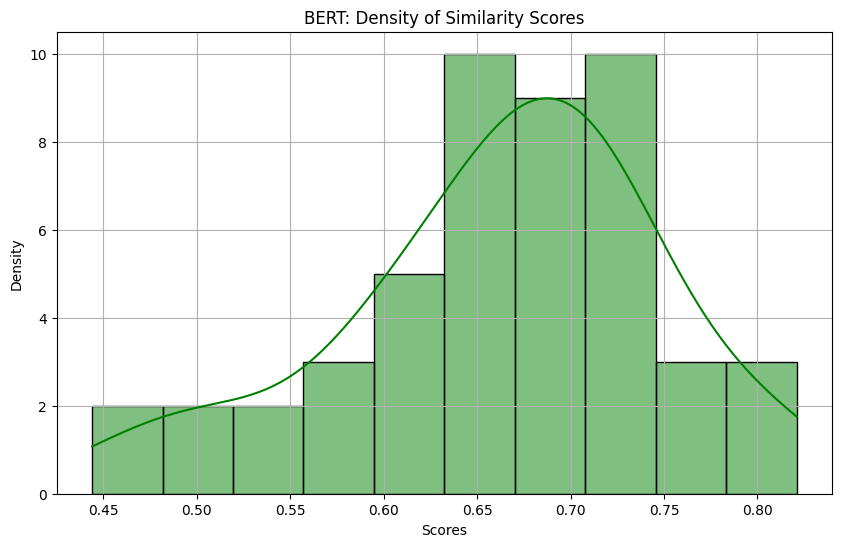

In [14]:
# Plotting the histogram and KDE of the scores
plt.figure(figsize=(10, 6))
sns.histplot(similarity_scores, kde=True, color='green', bins=10)
plt.title('BERT: Density of Similarity Scores')
plt.xlabel('Scores')
plt.ylabel('Density')
plt.grid(True)
plt.show()


### Supplementary code

#### Calculate Sentence Embeddings and Find Closest Standardized Phrases

Here we convert sentences into vectors and find the most similar phrases from a list. Then split each sentence into smaller parts and find the closest phrases for these parts.

In [15]:
# Calculate vectors for each sentence
embeddings = [encode(text) for text in texts]

# Find the closest phrases for each sentence
for text, embedding in zip(texts, embeddings):
    print(text)
    similarities = np.array([cosine_similarity(embedding, term_embedding)[0][0] for term_embedding in term_embeddings])

    # Calculate similarity scores
    scores = [list(i) for i in zip(standardized_phrases, similarities)]
    scores.sort(key=lambda x: -x[1])  # Sort scores in descending order

    for (term, similarity) in scores:
        print(f"{similarity:.2f} {term}")
    print()

    # Break down the sentence into phrases
    words = [word.strip() for word in text.split(' ') if len(word.strip()) > 0]
    sentences = [' '.join(words[i:]) for i in range(len(words))]

    # Find the closest standardized phrase for each breakdown
    for sentence in sentences:
        embedding = encode(sentence)
        similarities = np.array([cosine_similarity(embedding, term_embedding)[0][0] for term_embedding in term_embeddings])
        idx = np.argmax(similarities)
        print(f"{sentence} - {standardized_phrases[idx]} ({similarities[idx]:.2f})")


In today's meeting, we discussed a variety of issues affecting our department
0.53 Maintain a high standard
0.51 Implement best practices
0.50 Facilitate collaboration
0.50 Maximize stakeholder value
0.49 Demonstrate leadership
0.48 Conduct an analysis
0.48 Monitor performance metrics
0.47 Enhance productivity
0.44 Exercise due diligence
0.43 Foster innovation
0.43 Streamline operations
0.43 Utilise resources
0.42 Ensure compliance
0.42 Drive growth
0.42 Leverage synergies
0.41 Prioritise tasks
0.40 Gauge effectiveness
0.40 Execute strategies
0.37 Champion change
0.35 Optimal performance

In today's meeting, we discussed a variety of issues affecting our department - Maintain a high standard (0.53)
today's meeting, we discussed a variety of issues affecting our department - Maintain a high standard (0.53)
meeting, we discussed a variety of issues affecting our department - Facilitate collaboration (0.59)
we discussed a variety of issues affecting our department - Implement best practic

#### Calculate Weight Coefficients for Phrase Length Influence on Vector Similarity

The main idea is that as the number of words in a phrase increases (from 2 to 6 words), the similarity of their vectors to the vectors of standard phrases decreases.

To compare similarity scores for different phrase lengths, we need to divide them by normalization coefficients.

Here's how to calculate these coefficients: Take a sentence and find the highest similarity to standard phrases for each phrase length. Normalize these scores by dividing by the score for phrases with two words. Then, average these normalized scores across all sentences in the text.

In [16]:
# Calculate weight coefficients to account for phrase length
sims = []

for text in texts:
    # Calculate the maximum similarity for different phrase lengths within the text
    sim_max = {}

    # Iterate through different phrase lengths (from 2 to 6 words)
    for word_num in range(2, 7):
        sim_max[word_num] = []
        words = [word.strip() for word in text.split(' ') if len(word.strip()) > 0]
        sentences = [' '.join(words[i:i+word_num]) for i in range(len(words) - word_num)]

        for sentence in sentences:
            embedding = encode(sentence)
            # Calculate and store cosine similarities between the sentence embedding and term embeddings
            similarities = np.array([cosine_similarity(embedding, term_embedding)[0][0] for term_embedding in term_embeddings])
            idx = np.argmax(similarities)
            sim_max[word_num].append(similarities[idx])

    # Get the maximum similarity for each word length
    sim_max = {word_num: max(similarities) for word_num, similarities in sim_max.items()}
    sim_max = {word_num: similarity / sim_max[2] for word_num, similarity in sim_max.items()}
    sim_max['text'] = text

    sims.append(sim_max)

# Determine average weight coefficients for each phrase length
coefs = {}
for word_num in list(sims[0].keys())[:-1]:
    # Collect similarities for each word length across all texts
    tmp = []
    for sim in sims:
        tmp.append(sim[word_num])
    coefs[word_num] = sum(tmp) / len(tmp)

print('Weight coefficients to account for the influence of phrase length on vector similarity:')
print(coefs)


Weight coefficients to account for the influence of phrase length on vector similarity:
{2: 1.0, 3: 0.9410718571056019, 4: 0.9061189673163674, 5: 0.8910409428856589, 6: 0.8603814352642406}


### Areas of improvement
* Continue testing the model; the current results are based on the initial implementation without thorough testing.
* Explore other POS combinations.
* Use sentence transformers instead of word embeddings.
* Combine cosine similarity with other metrics.


## Comparative Analysis and discussion

### Comparing BERT and (BERT + Spacy phrases)

The integration of Spacy for phrase extraction significantly enhances the model's performance. The combination of Spacy phrase extraction and the BERT-based similarity evaluation produces higher quality suggestions, in terms of contextual relevance and diversity of suggestions.

**Conclusion**: [BERT + Spacy phrases] outperforms BERT alone

### Comparing Spacy and BERT Approaches



Direct comparison between **BERT + Spacy** and **Spacy** alone shows these results:

BERT has a higher similarity rate, often scoring over 0.8, while **Spacy** alone rarely scores over 0.7.

However, the **BERT + Spacy** approach provides less meaningful suggestions and lacks in semantic accuracy, contextual relevance, and diversity of suggestions compared to using **Spacy** alone.



## Conclusion

**Spacy** outperforms current version of **[BERT + Spacy phrases]** in terms of contextual relevance, contextual relevance, and diversity of suggestions while showing lower similarity rates.

Considering areas of improvement, **BERT + Spacy phrases** needs enhancement and has the potential to outperform the **Spacy** approach. The areas of improvement include continuing to test the model, as the current results are based on the initial implementation, exploring other POS combinations, using sentence transformers instead of word embeddings, and combining cosine similarity with other metrics.